# Convolutional Neural Networks: Application

Welcome to Course 4's second assignment! In this notebook, you will:

- Implement a fully functioning ConvNet using PyTorch 

**After this assignment you will be able to:**

- Build and train a ConvNet in PyTorch for a classification problem 

In the previous assignment, you built helper functions using numpy to understand the mechanics behind convolutional neural networks. Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions you can simply call. 

As usual, we will start by loading in the packages. 

In [2]:
from cnn_utils import *
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from IPython.display import clear_output  # for showing the plot dynamically

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Run the next cell to load the "SIGNS" dataset you are going to use.

## Loading the data

In [4]:
X_train, X_test, y_train, y_test = get_data()

As a reminder, the SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

<img src="images/SIGNS.png" style="width:800px;height:300px;">

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples. 

Text(0.5, 1.0, 'y = 5')

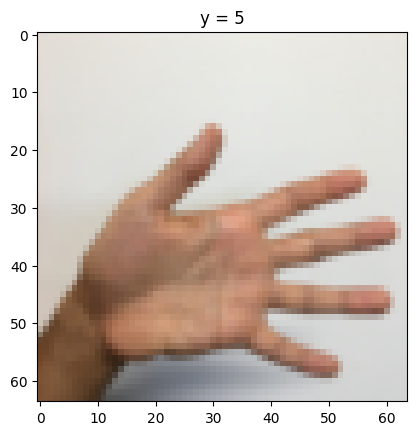

In [6]:
#Example of a picture
index = 6
img = X_train[0].numpy().transpose([1, 2, 0])
plt.imshow(img)
plt.title(f"y = {y_train[0]}")

In Course 2, you had built a fully-connected network for this dataset. But since this is an image dataset, it is more natural to apply a ConvNet to it.

To get started, let's examine the shapes of your data. 

In [7]:
print("number of training examples =", len(X_train))
print("number of test examples =", len(X_test))
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

number of training examples = 1080
number of test examples = 120
X_train shape: torch.Size([1080, 3, 64, 64])
y_train shape: torch.Size([1080])
X_test shape: torch.Size([120, 3, 64, 64])
y_test shape: torch.Size([120])


## Model

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # original shape: 3 x 64 x 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # shape: 8 x 32 x 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        # shape: 16 x 16 x 16
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        # shape: 32 x 8 x 8
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 6)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

    def pred(self, x):
        '''
        Convert the one-hot prediction as a single number.
        '''
        return torch.argmax(self.forward(x), dim=1)

    def score(self, X_test, y_test):
        """
        Compute the accuracy.
        """
        pred = self.pred(X_test)
        return (pred == y_test).float().mean()

In [9]:
model = CNN().to(device)

## Train

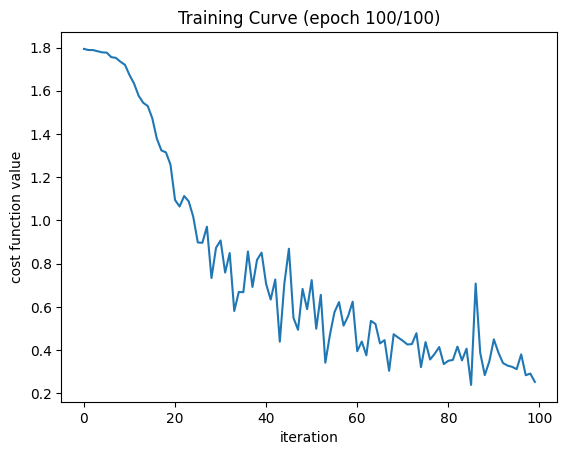

In [10]:
model.train()
n_epochs = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

cost_hist = []  # collect history data
for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        
        
    cost_hist.append(loss.item())
    # dynamic plot of the training curve
    clear_output(wait=True)
    plt.title(f'Training Curve (epoch {epoch+1}/{n_epochs})')
    plt.xlabel('iteration')
    plt.ylabel('cost function value')
    plt.plot(cost_hist)
    plt.show()

## Test

First, we will compute the accuracy of our model over the test set.

In [11]:
model.eval()
X_test = X_test.to(device)
y_test = y_test.to(device)
print(f'Test set accuracy: {model.score(X_test, y_test).item()}')

Test set accuracy: 0.8416666984558105


Randomly choose one example from the test set and show predction.

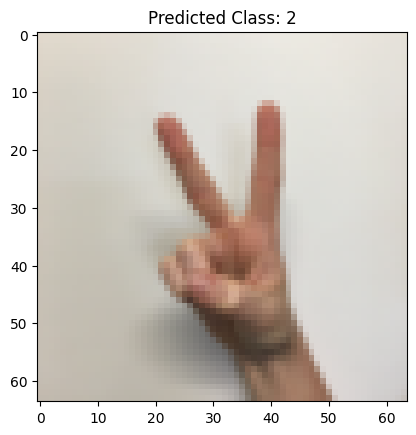

In [12]:
index = torch.randint(len(X_test), size=(1,)).item()
y_pred = model.pred(X_test[index].unsqueeze(0))
plt.imshow(X_test[index].permute(1, 2, 0).cpu())
plt.title(f'Predicted Class: {y_pred.item()}')
plt.show()